<a href="https://colab.research.google.com/github/sureshmecad/Higgs-Boson-Decay-TMLC/blob/main/4_Higgs_Boson_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **Approach 01:**
 - selected 10 features

 - df['DER_mass_MMC'] = df['DER_mass_MMC'].replace(-999.0, np.nan) ---> **Replace -999.0 with NaN**
 
 - df['DER_mass_MMC'] = df['DER_mass_MMC'].fillna(df['DER_mass_MMC'].median()) ---> **Replace NaN with median**

#### **Approach 02:**
 - selected 10 features

 - df['DER_mass_MMC'] = df['DER_mass_MMC'].replace(-999.0, np.nan) ---> **Replace -999.0 with NaN**
 
 - df['DER_mass_MMC'] = df['DER_mass_MMC'].fillna(df['DER_mass_MMC'].median()) ---> **Replace NaN with median**

 -------------------

 - cols = ["DER_mass_transverse_met_lep", "DER_met_phi_centrality", "DER_pt_h"]
 
   df[cols] = df[cols].replace(['0', 0], np.nan) ---> **Replace Zeros with NaN**

 - df['DER_mass_transverse_met_lep'] = df['DER_mass_transverse_met_lep'].fillna(df['DER_mass_transverse_met_lep'].median())

   df['DER_met_phi_centrality'] = df['DER_met_phi_centrality'].fillna(df['DER_met_phi_centrality'].median())

  df['DER_pt_h'] = df['DER_pt_h'].fillna(df['DER_pt_h'].median()) ---> **Replace NaN with median**

### **Approach 02 given better results**

----------------------------

### Table of Contents

* [1) Import Libraries](#1)

* [2) Import Data And Preprocessing](#2)

* [3) Feature Engineering](#3)

   * [3.1) Missing Values](#3.1)

* [4) Modelling](#4)

  * [4.1) XGBoost(Base Model)](#4.1)

  * [4.2) XGBoost(Hyperparameter Tuning1)](#4.2)

  * [4.3) XGBoost(Hyperparameter Tuning2)](#4.3)

  * [4.4) LGBM](#4.4)

* [5) AUC-ROC Curve](#5)

* [6) Model Explainability (Explainable AI)](#6)

  * [6.1) LIME](#6.1)

  * [6.2) SHAP](#6.2)

* [7) Saving Files (Joblib)](#7)

* [REFERENCES](#7)

### **1) Import Libraries**

In [1]:
# Read Data
import numpy as np                     # Linear Algebra (calculate the mean and standard deviation)
import pandas as pd                    # manipulate data, data processing, load csv file I/O (e.g. pd.read_csv)

# Visualization
import seaborn as sns                  # Visualization using seaborn
import matplotlib.pyplot as plt        # Visualization using matplotlib
%matplotlib inline

# style
plt.style.use("fivethirtyeight")       # Set Graphs Background style using matplotlib
sns.set_style("darkgrid")              # Set Graphs Background style using seaborn

import warnings                        # Ignore Warnings
warnings.filterwarnings("ignore")

In [2]:
import scipy.stats as stats

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, cohen_kappa_score

from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier, plot_importance
from sklearn.naive_bayes import GaussianNB

#### **2) Import Data And Preprocessing**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
Higgs = pd.read_csv("/content/drive/MyDrive/TMLC/Higgs-Boson.zip")

In [6]:
display(Higgs.head(3))
display(Higgs.tail(3))

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,1.582,1.396,0.2,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,125.157,0.879,1.414,-999.0,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,197.814,3.776,1.414,-999.0,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b


,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
249997,349997,105.457,60.526,75.839,39.757,-999.0,-999.0,-999.0,2.390,22.183,120.462,1.202,0.529,-999.0,35.636,-0.266,-3.132,42.834,0.381,0.851,23.419,-2.890,198.907,1,41.992,1.8,-0.166,-999.0,-999.0,-999.0,41.992,0.018636,s
249998,349998,94.951,19.362,68.812,13.504,-999.0,-999.0,-999.0,3.365,13.504,55.859,0.999,1.414,-999.0,27.944,-2.211,2.792,27.915,-0.874,-0.296,12.150,0.811,112.718,0,-999.000,-999.0,-999.000,-999.0,-999.0,-999.0,0.000,1.681611,b
249999,349999,-999.000,72.756,70.831,7.479,-999.0,-999.0,-999.0,2.025,7.479,83.240,0.936,-1.411,-999.0,43.003,1.685,2.653,40.236,1.490,0.637,40.729,-1.596,99.405,0,-999.000,-999.0,-999.000,-999.0,-999.0,-999.0,0.000,1.877474,b


In [7]:
Higgs.shape

(250000, 33)

In [8]:
original = Higgs.copy()

#### **3) Feature Engineering**

In [9]:
Higgs.drop('EventId', axis=1, inplace=True)

#### **3.1) Missing Values**

In [10]:
# Listing Number of missing values by feature column wise
total = Higgs.isnull().sum().sort_values(ascending=False)
total = total[total > 0]
total

Series([], dtype: int64)

In [11]:
Higgs.isnull().sum().sum()

0

In [12]:
feature_columns = ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_deltar_tau_lep', 'PRI_tau_pt', 'DER_met_phi_centrality', 'DER_pt_h', 'PRI_met']

df = pd.DataFrame(Higgs, columns = feature_columns)
df.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_deltar_tau_lep,PRI_tau_pt,DER_met_phi_centrality,DER_pt_h,PRI_met
0,138.470,51.655,97.827,3.064,32.638,1.396,27.980,16.824
1,160.937,68.768,103.235,3.473,42.014,1.414,48.146,44.704
2,-999.000,162.172,125.953,3.148,32.154,1.414,35.635,54.283
3,143.905,81.417,80.943,3.310,22.647,-1.285,0.414,31.082
4,175.864,16.915,134.805,3.891,28.209,-1.385,16.405,2.723


In [13]:
(df == -999.0).sum(axis=0)

DER_mass_MMC                   38114
DER_mass_transverse_met_lep        0
DER_mass_vis                       0
DER_deltar_tau_lep                 0
PRI_tau_pt                         0
DER_met_phi_centrality             0
DER_pt_h                           0
PRI_met                            0
dtype: int64

In [14]:
(df == 0).sum(axis=0)

DER_mass_MMC                    0
DER_mass_transverse_met_lep     3
DER_mass_vis                    0
DER_deltar_tau_lep              0
PRI_tau_pt                      0
DER_met_phi_centrality         53
DER_pt_h                       41
PRI_met                         0
dtype: int64

df['DER_mass_transverse_met_lep'] = df['DER_mass_transverse_met_lep'].replace(0, 46.523)

df['DER_met_phi_centrality'] = df['DER_met_phi_centrality'].replace(0, -0.356)

df['DER_pt_h'] = df['DER_pt_h'].replace(0, 38.467)

#### **Replace -999.0 & 0's with NaN and fill with median**

In [15]:
df['DER_mass_MMC'] = df['DER_mass_MMC'].replace(-999.0, np.nan)

In [16]:
df['DER_mass_MMC'] = df['DER_mass_MMC'].fillna(df['DER_mass_MMC'].median())

In [17]:
cols = ["DER_mass_transverse_met_lep", "DER_met_phi_centrality", "DER_pt_h"]
 
df[cols] = df[cols].replace(['0', 0], np.nan)

In [18]:
df['DER_mass_transverse_met_lep'] = df['DER_mass_transverse_met_lep'].fillna(df['DER_mass_transverse_met_lep'].median())
df['DER_met_phi_centrality'] = df['DER_met_phi_centrality'].fillna(df['DER_met_phi_centrality'].median())
df['DER_pt_h'] = df['DER_pt_h'].fillna(df['DER_pt_h'].median())

In [19]:
(df == -999.0).sum(axis=0)

DER_mass_MMC                   0
DER_mass_transverse_met_lep    0
DER_mass_vis                   0
DER_deltar_tau_lep             0
PRI_tau_pt                     0
DER_met_phi_centrality         0
DER_pt_h                       0
PRI_met                        0
dtype: int64

In [20]:
(df == 0).sum(axis=0)

DER_mass_MMC                   0
DER_mass_transverse_met_lep    0
DER_mass_vis                   0
DER_deltar_tau_lep             0
PRI_tau_pt                     0
DER_met_phi_centrality         0
DER_pt_h                       0
PRI_met                        0
dtype: int64

In [21]:
Higgs['Label'] = Higgs['Label'].map({'b':1, 's':0})

### **4) Modelling** 

In [22]:
X = df
y = Higgs['Label']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [24]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(200000, 8)
(200000,)
(50000, 8)
(50000,)


### **4.1) XGBoost**

#### **Base Model**

In [25]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [26]:
# make predictions for test set
y_pred_xgb = xgb.predict(X_test)
predictions = [round(value) for value in y_pred_xgb]

In [27]:
print("XGBoost : Train Score {:.2f} & Test Score {:.2f}".format(xgb.score(X_train, y_train), xgb.score(X_test, y_test)))
print('-'*70)
print("\n\nConfusion matrix \n\n", confusion_matrix(y_test, y_pred_xgb))
print('-'*70)
print("\n\nClassification Report\n\n", classification_report(y_test, y_pred_xgb))

XGBoost : Train Score 0.82 & Test Score 0.82
----------------------------------------------------------------------


Confusion matrix 

 [[11885  5244]
 [ 3640 29231]]
----------------------------------------------------------------------


Classification Report

               precision    recall  f1-score   support

           0       0.77      0.69      0.73     17129
           1       0.85      0.89      0.87     32871

    accuracy                           0.82     50000
   macro avg       0.81      0.79      0.80     50000
weighted avg       0.82      0.82      0.82     50000



#### **Hyperparameter Tuning: 1**

In [28]:
xgb1 = XGBClassifier(max_depth=5, n_estimators=100, min_samples_leaf = 200, max_features = 10, learning_rate = 0.5)
xgb1.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=5, max_features=10,
              min_child_weight=1, min_samples_leaf=200, missing=None,
              n_estimators=100, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [29]:
# make predictions for test set
y_pred_xgb1 = xgb1.predict(X_test)
predictions1 = [round(value) for value in y_pred_xgb1]

In [30]:
print("XGBoost : Train Score {:.2f} & Test Score {:.2f}".format(xgb1.score(X_train, y_train), xgb1.score(X_test, y_test)))
print('-'*70)
print("\n\nConfusion matrix \n\n", confusion_matrix(y_test, y_pred_xgb1))
print('-'*70)
print("\n\nClassification Report\n\n", classification_report(y_test, y_pred_xgb1))

XGBoost : Train Score 0.84 & Test Score 0.82
----------------------------------------------------------------------


Confusion matrix 

 [[12150  4979]
 [ 3796 29075]]
----------------------------------------------------------------------


Classification Report

               precision    recall  f1-score   support

           0       0.76      0.71      0.73     17129
           1       0.85      0.88      0.87     32871

    accuracy                           0.82     50000
   macro avg       0.81      0.80      0.80     50000
weighted avg       0.82      0.82      0.82     50000



#### **Hyperparameter Tuning: 2**

In [31]:
xgb2 = XGBClassifier(max_depth=6, n_estimators=120, learning_rate = 0.1)
xgb2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=120, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [32]:
# make predictions for test set
y_pred_xgb2 = xgb2.predict(X_test)
predictions2 = [round(value) for value in y_pred_xgb2]

In [33]:
print("XGBoost : Train Score {:.2f} & Test Score {:.2f}".format(xgb2.score(X_train, y_train), xgb2.score(X_test, y_test)))
print('-'*70)
print("\n\nConfusion matrix \n\n", confusion_matrix(y_test, y_pred_xgb2))
print('-'*70)
print("\n\nClassification Report\n\n", classification_report(y_test, y_pred_xgb2))

XGBoost : Train Score 0.83 & Test Score 0.83
----------------------------------------------------------------------


Confusion matrix 

 [[12052  5077]
 [ 3597 29274]]
----------------------------------------------------------------------


Classification Report

               precision    recall  f1-score   support

           0       0.77      0.70      0.74     17129
           1       0.85      0.89      0.87     32871

    accuracy                           0.83     50000
   macro avg       0.81      0.80      0.80     50000
weighted avg       0.82      0.83      0.82     50000



### **4.2) LGBM**

In [34]:
LGB = LGBMClassifier()
LGB.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [35]:
y_pred_LGB = LGB.predict(X_test)

In [36]:
print("XGBoost : Train Score {:.2f} & Test Score {:.2f}".format(LGB.score(X_train, y_train), LGB.score(X_test, y_test)))
print('-'*70)
print("\n\nConfusion matrix \n\n",confusion_matrix(y_test, y_pred_LGB))
print('-'*70)
print("\n\nClassification Report\n\n",classification_report(y_test, y_pred_LGB))

XGBoost : Train Score 0.83 & Test Score 0.83
----------------------------------------------------------------------


Confusion matrix 

 [[12080  5049]
 [ 3595 29276]]
----------------------------------------------------------------------


Classification Report

               precision    recall  f1-score   support

           0       0.77      0.71      0.74     17129
           1       0.85      0.89      0.87     32871

    accuracy                           0.83     50000
   macro avg       0.81      0.80      0.80     50000
weighted avg       0.82      0.83      0.83     50000



### **5) AUC-ROC Curve**

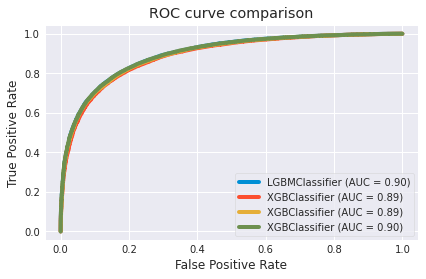

In [39]:
# AUC-ROC Curve
#plt.figure(figsize=(7,5))
from sklearn.metrics import plot_roc_curve

m1_roc = plot_roc_curve(LGB, X_test, y_test)
plot_roc_curve(xgb, X_test, y_test, ax = m1_roc.ax_)
plot_roc_curve(xgb1, X_test, y_test, ax = m1_roc.ax_)
plot_roc_curve(xgb2, X_test, y_test, ax = m1_roc.ax_)

plt.title("ROC curve comparison")
plt.show()

#### **6) Model Explainability (Explainable AI)**

#### **6.1) LIME**

In [40]:
!pip install lime

     |████████████████████████████████| 275 kB 5.3 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=09d88ca04dd7b038aebf51c09d1abaee9879a01f2b2c1b5495e7ba8ed647c033
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [41]:
import lime
from lime import lime_tabular

interpretor = lime_tabular.LimeTabularExplainer(
    training_data = np.array(X_train),
    feature_names = X_train.columns,
    mode='classification'
)

In [43]:
exp = interpretor.explain_instance(
    data_row = X_test.iloc[10], ##new data
    predict_fn = LGB.predict_proba
)

exp.show_in_notebook(show_table=True)

#### **6.2) SHAP**

In [45]:
!pip install shap

     |████████████████████████████████| 356 kB 5.4 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491647 sha256=d65ece5b0ccc2ff0423f0bf36b61494b52b3b2b00ebfe72e5626e0438adcf58f
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [78]:
import shap
shap.initjs()

In [75]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(LGB)
# Calculate Shap values
shap_values = explainer.shap_values(X)

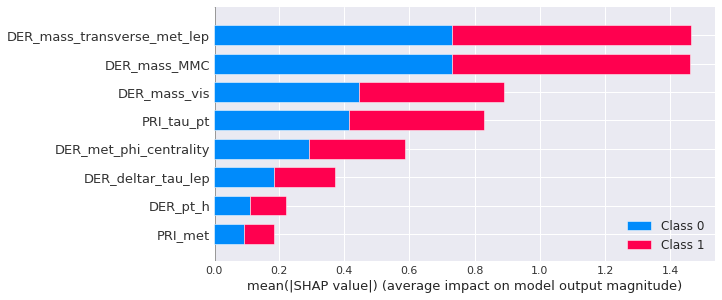

In [49]:
# SHAP Feature importance
shap.summary_plot(shap_values, X_train, feature_names=df.columns, plot_type="bar")

In [76]:
X_display, y_display = X, y

In [82]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_display.iloc[0,:])

#### **SHAP Summary Plot**

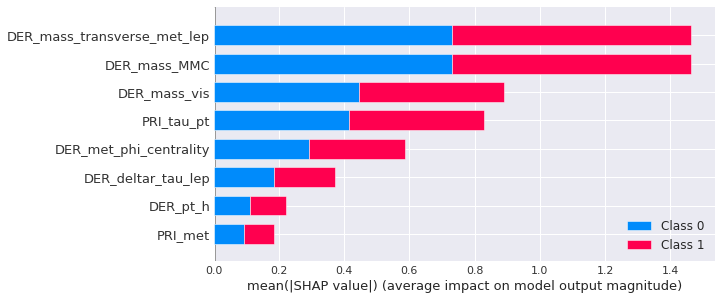

In [80]:
shap.summary_plot(shap_values, X)

#### **SHAP Dependence Plots**

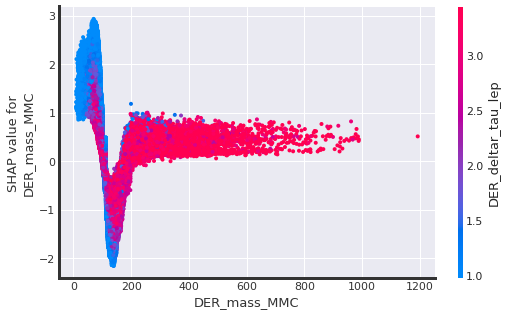

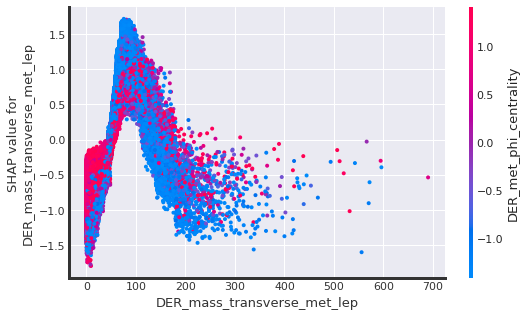

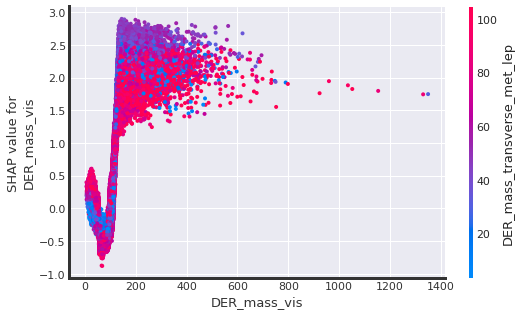

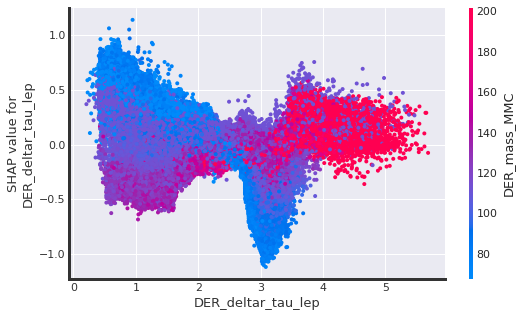

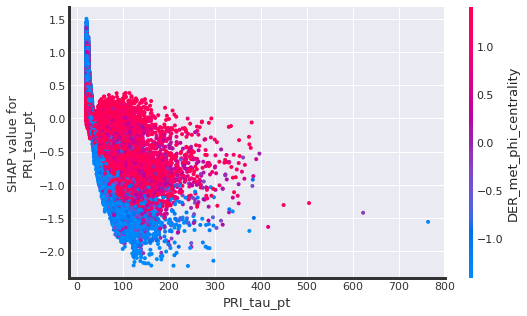

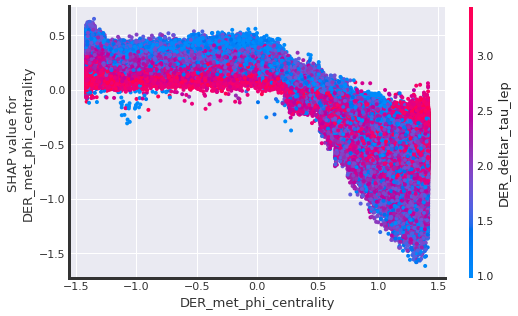

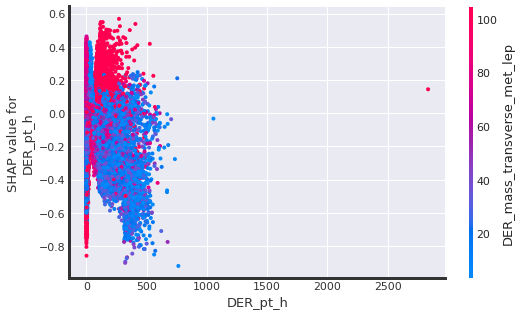

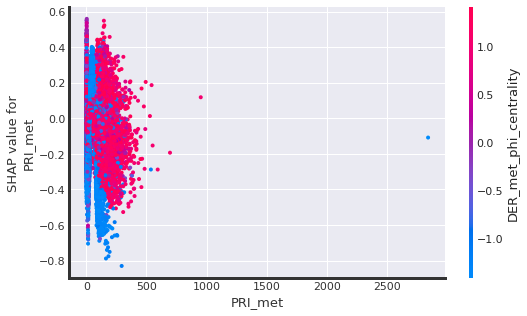

In [81]:
for name in X_train.columns:
  shap.dependence_plot(name, shap_values[1], X, display_features=X_display)

### **7) Saving Files**

In [37]:
import joblib

with open("model.joblib", 'wb') as model:
    joblib.dump(LGB, model, compress=1)

In [38]:
with open("features.joblib", 'wb') as ft:
    joblib.dump(feature_columns, ft, compress=1)

### **REFERENCE**

- https://github.com/cbracher69/Kaggle-Higgs-Boson-Challenge/blob/master/Higgs%20Linear-Gaussian%20Model%20Archive.ipynb

- https://www.kaggle.com/imeintanis/identifying-higgs-boson-t-sne-umap-rapids

#### **SHAP**

- https://towardsdatascience.com/explainable-ai-xai-with-shap-regression-problem-b2d63fdca670

- https://github.com/slundberg/shap

- https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html